In [55]:
import numpy as np
import pandas as pd
from gsprep.visual_tools.visual import idisplay, display
from scipy import ndimage
import seaborn as sns
from sklearn import metrics
import nibabel as nib
import os

# Creating a baseline estimator for onset prediction based on non-contrast and perfusion CT using lesion water uptake

ischemic core defined on perfusion -> measure ischemic core lesion density (Dischemic) in NCCT
-> then measure symetry in normal tissue of the contralateral hemisphere (Dnormal).
ROIs were segmented with semi-automatic edge detection and sampled between 20 and 80 HU.

%water uptake = (1 − (Dischemic / Dnormal) × 100

In [32]:
imaging_dataset_path = '/Users/jk1/stroke_datasets/dataset_files/perfusion_data_sets/temp_split_datasets/train_with_ncct_dataset_with_onset_to_imaging_with_core_with_penumbra.npz'
label_file_path = '/Users/jk1/OneDrive - unige.ch/stroke_research/geneva_stroke_dataset/clinical_data/multi_annual_joined_data/scope_joined_variables/onset_prediction/with_imaging_curated_completed_joined_anon_outcome_df.xlsx'

id_variable = 'pid'
outcome = 'onset_to_imaging'
channels = [0,1,2,3,4,5,6]
apply_csf_mask = False

In [33]:
ids = np.load(imaging_dataset_path, allow_pickle=True)['ids']

outcomes_df = pd.read_excel(label_file_path)
labels = np.array([outcomes_df.loc[outcomes_df[id_variable] == subj_id, outcome].iloc[0] for
                   subj_id in ids])

raw_images = np.load(imaging_dataset_path, allow_pickle=True)['ct_inputs'][..., channels]

if raw_images.ndim < 5:
    raw_images = np.expand_dims(raw_images, axis=-1)

# Apply masks
raw_masks = np.load(imaging_dataset_path, allow_pickle=True)['brain_masks']
raw_masks = np.expand_dims(raw_masks, axis=-1)
images = raw_images * raw_masks

In [34]:
n_subj = len(ids)
rCBF_over_threshold = images[..., 5]
penumbra = images[..., 6]
ncct = images[..., 4]

strict_core = rCBF_over_threshold * penumbra

In [35]:
from skimage.measure import label

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    return largestCC

Retain only largest connected component

In [36]:
cc_limited_core = [getLargestCC(strict_core[i]) for i in range(n_subj)]

Limit core to only one half of the brain

In [37]:
image_half = int(images.shape[1] / 2)
left_half_filter = np.zeros(images.shape[1:-1])
right_half_filter = np.zeros(images.shape[1:-1])
right_half_filter[0:image_half] = 1
left_half_filter[image_half:] = 1
x_center_of_mass = [ndimage.measurements.center_of_mass(strict_core[i])[0] for i in range(n_subj)]

In [38]:
laterally_limited_core = np.copy(strict_core)
for i in range(n_subj):
    # if center of core is on the left side of the image
    if x_center_of_mass[i] < image_half:
        laterally_limited_core[i] *= right_half_filter
    # if center of core is on the right side of the image
    else:
        laterally_limited_core[i] *= left_half_filter



In [39]:
mirrored_laterally_limited_core_mask = np.flip(laterally_limited_core, axis=1)



In [40]:
from gsd_pipeline.dataset_tools.add_core_map import dilation_structure_2d
from gsprep.utils.smoothing import gaussian_smoothing

dilation_structure = dilation_structure_2d

# Create CSF mask
low_bounded_ncct = ncct[ncct > 0]
up_and_low_bounded_ncct = low_bounded_ncct[low_bounded_ncct < 100]
# threshold = 20
threshold = np.percentile(up_and_low_bounded_ncct, 5)
csf_mask = gaussian_smoothing(ncct[..., None], kernel_width=3) < threshold
enlarged_csf_mask = np.array(
    [ndimage.binary_dilation(csf_mask[idx, ..., 0], structure=dilation_structure(1)) for idx in range(csf_mask.shape[0])])
inv_csf_mask = -1 * enlarged_csf_mask + 1

In [41]:
if apply_csf_mask:
    laterally_limited_core = laterally_limited_core * inv_csf_mask
    mirrored_laterally_limited_core_mask = mirrored_laterally_limited_core_mask * inv_csf_mask


In [42]:
mean_ischemic_density = [np.mean(ncct[i][np.nonzero(laterally_limited_core[i])])
                                 for i in range(n_subj)]

mean_non_ischemic_density = [np.mean(ncct[i][np.nonzero(mirrored_laterally_limited_core_mask[i])])
                                 for i in range(n_subj)]

In [43]:
water_uptake = (1 - np.divide(mean_ischemic_density, mean_non_ischemic_density)) * 100

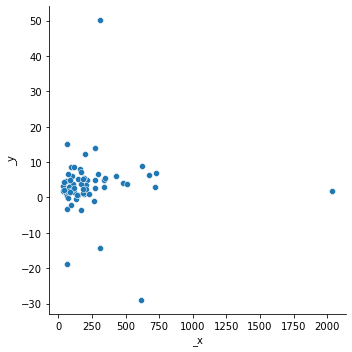

In [44]:

sns.relplot(x=labels, y=water_uptake)

In [45]:

binary_labels = labels > 4.5*60

metrics.roc_auc_score(binary_labels, water_uptake)

0.6884531590413943

In [46]:
df = pd.DataFrame(zip(labels, binary_labels, mean_ischemic_density, mean_non_ischemic_density, water_uptake),
                  columns=['onset_to_imaging', 'binary_labels', 'mean_ischemic_density', 'mean_non_ischemic_density', 'water_uptake'])

In [47]:
df['mean_ischemic_density'].describe()

count    69.000000
mean     32.986171
std       3.837835
min      17.726702
25%      31.662162
50%      33.648066
75%      35.135079
max      41.416667
Name: mean_ischemic_density, dtype: float64

In [48]:
df['mean_non_ischemic_density'].describe()

count    69.000000
mean     34.200159
std       3.640036
min      18.471204
25%      32.638774
50%      34.931787
75%      36.353945
max      40.121899
Name: mean_non_ischemic_density, dtype: float64

In [49]:
print(df[df['binary_labels'] == 0]['mean_ischemic_density'].describe())
print(df[df['binary_labels'] == 0]['mean_non_ischemic_density'].describe())
print(df[df['binary_labels'] == 0]['water_uptake'].describe())

count    51.000000
mean     33.670339
std       2.739012
min      24.324895
25%      32.454099
50%      34.060769
75%      35.177248
max      41.416667
Name: mean_ischemic_density, dtype: float64
count    51.000000
mean     34.637097
std       2.885054
min      25.548523
25%      33.314710
50%      35.093702
75%      36.464875
max      40.121899
Name: mean_non_ischemic_density, dtype: float64
count    51.000000
mean      2.668108
std       4.612274
min     -18.899522
25%       1.250078
50%       2.286566
75%       4.690348
max      15.171483
Name: water_uptake, dtype: float64


In [31]:
print(df[df['binary_labels'] == 1]['mean_ischemic_density'].describe())
print(df[df['binary_labels'] == 1]['mean_non_ischemic_density'].describe())
print(df[df['binary_labels'] == 1]['water_uptake'].describe())

count    18.000000
mean     34.132528
std       2.699602
min      29.728205
25%      32.459153
50%      34.344683
75%      35.190118
max      42.113990
Name: mean_ischemic_density, dtype: float64
count    18.000000
mean     35.935497
std       2.399020
min      31.326923
25%      34.067822
50%      36.352852
75%      36.992363
max      40.702684
Name: mean_non_ischemic_density, dtype: float64
count    18.000000
mean      4.890576
std       6.454923
min     -16.854610
25%       4.080240
50%       5.159741
75%       8.176611
max      16.412829
Name: water_uptake, dtype: float64


In [63]:
subj_id = 57
ids[subj_id]

'subj-5af90b8b'

In [64]:
mean_ischemic_density[subj_id]

39.27105263157895

In [65]:
mean_non_ischemic_density[subj_id]

30.45263157894737

In [66]:
water_uptake[subj_id]

-28.957829243000344

In [67]:
labels[subj_id]/60

10.233333333337214

In [68]:
output_dir = '/Users/jk1/temp/scope_onset_exploration'

ncct_img = nib.Nifti1Image(ncct[subj_id], np.eye(4))
nib.save(ncct_img, os.path.join(output_dir, f'{ids[subj_id]}_ncct.nii'))

lesion_img = nib.Nifti1Image(laterally_limited_core[subj_id], np.eye(4))
nib.save(lesion_img, os.path.join(output_dir, f'{ids[subj_id]}_lesion.nii'))

mirrored_lesion_img = nib.Nifti1Image(mirrored_laterally_limited_core_mask[subj_id], np.eye(4))
nib.save(mirrored_lesion_img, os.path.join(output_dir, f'{ids[subj_id]}_mirrored_lesion.nii'))

csf_img = nib.Nifti1Image(enlarged_csf_mask[subj_id].astype(int), np.eye(4))
nib.save(csf_img, os.path.join(output_dir, f'{ids[subj_id]}_csf.nii'))